## Data Pull -> Using previous volatility -> Training GARCH model -> Predicting volatitliy for next 500 days

In [42]:
#Libraries and fetching data

import yfinance as yf
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date

# Fetching data since 2010 till today
ticker= "TSLA"
start_date = "2010-01-01"
end_date = date.today().strftime("%Y-%m-%d")
tsla_data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


## Daily, Monthly and Annual Volatility!

╒═══════╤══════════════════════╤════════════════════════╤═══════════════════════╕
│       │  Daily Volatility %  │  Monthly Volatility %  │  Annual Volatility %  │
╞═══════╪══════════════════════╪════════════════════════╪═══════════════════════╡
│ Tesla │         3.62         │         16.58          │         57.43         │
╘═══════╧══════════════════════╧════════════════════════╧═══════════════════════╛


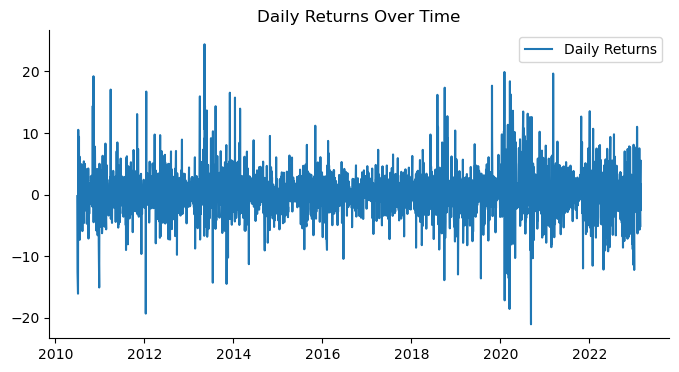

In [43]:
tsla_data['Return'] = 100 * (tsla_data['Close'].pct_change())
tsla_data.dropna(inplace=True)

fig,ax = plt.subplots(figsize=(8,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(tsla_data['Return'], label = 'Daily Returns')
plt.legend(loc='upper right')
plt.title('Daily Returns Over Time')

daily_volatility = tsla_data['Return'].std()
monthly_volatility = math.sqrt(21) * daily_volatility
annual_volatility = math.sqrt(252) * daily_volatility

from tabulate import tabulate
print(tabulate([['Tesla', daily_volatility, monthly_volatility, annual_volatility]],
               headers=['Daily Volatility %', 'Monthly Volatility %', 'Annual Volatility %'],
               tablefmt='fancy_grid', stralign='center', numalign='center', floatfmt=".2f"))

### The below data shows: mean return (mu) = 17.1%, long term average voalitility (omega) = 13%, short-run voalititly (alpha) = 3%, persistence of volatility (beta) = 95.7%


In [45]:
# Fitting GARCH model and forecasting volatility till 2024 September 20th
from arch import arch_model
from arch.__future__ import reindexing

garch_model = arch_model(tsla_data['Return'], p=1, q=1, mean='constant', vol='GARCH', dist='normal')
gm_result = garch_model.fit(disp='off')
print(gm_result.params)
print('\n')

mu          0.171850
omega       0.130736
alpha[1]    0.032224
beta[1]     0.957707
Name: params, dtype: float64




## Plot the historical volatility of the Tesla stock


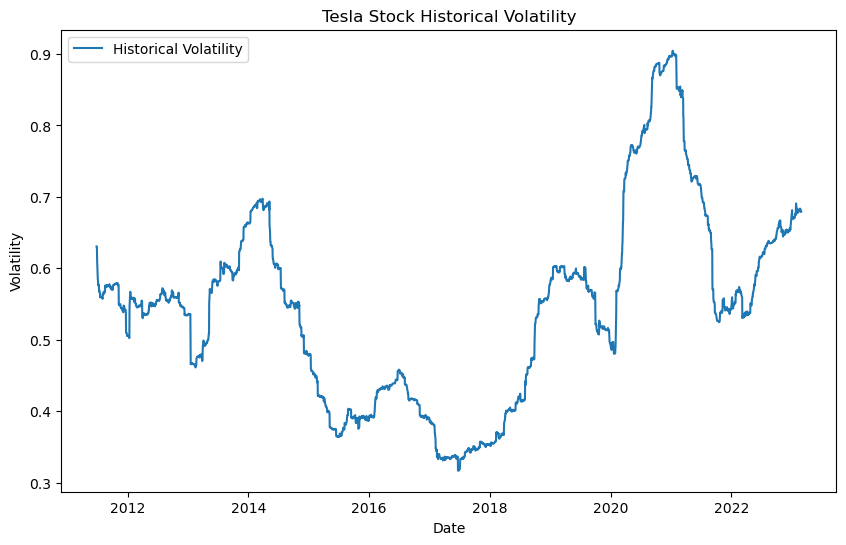

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(tesla['Date'], tesla['Volatility'], label='Historical Volatility')
plt.title('Tesla Stock Historical Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Tesla Volatility Forecast - GARCH Model')

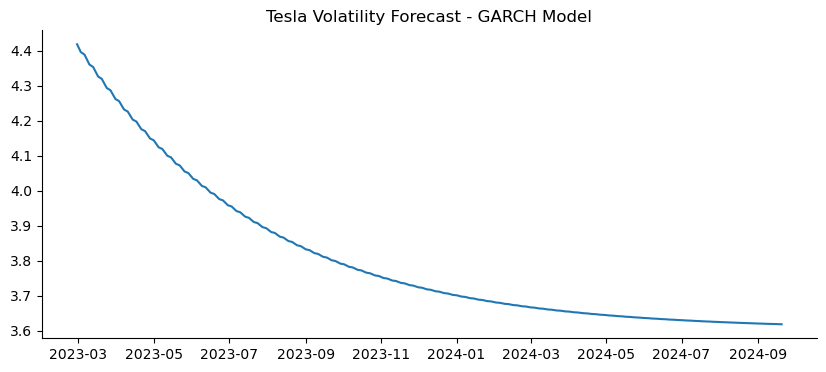

In [46]:
start_date = tsla_data.index[-1].date() + pd.Timedelta(days=1)
end_date = "2024-09-20"
forecast_horizon = pd.date_range(start_date, end_date, freq='B')
gm_forecast = gm_result.forecast(horizon=len(forecast_horizon), start=start_date)
forecast = pd.DataFrame(np.sqrt(gm_forecast.variance.values).T, index=forecast_horizon, columns=['Predicted Volatility'])

fig, ax = plt.subplots(figsize=(10, 4))
ax.spines[['top','right']].set_visible(False)
plt.plot(forecast)
plt.title('Tesla Volatility Forecast - GARCH Model')

Text(0.5, 1.0, 'Rolling Prediction')

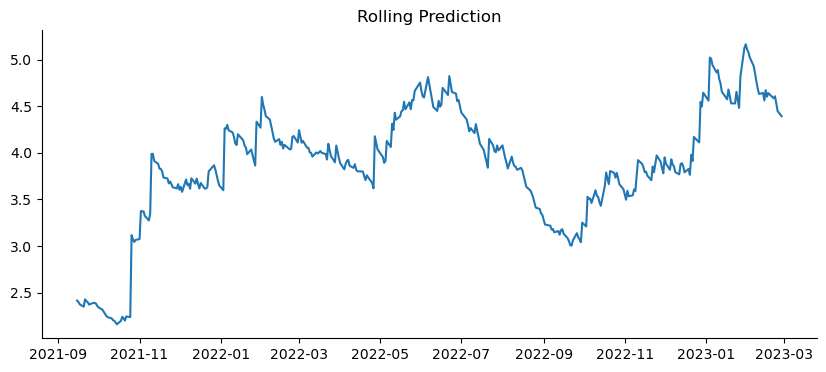

In [47]:
# Rolling prediction
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = tsla_data['Return'][:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=tsla_data['Return'].index[-365:])

fig, ax = plt.subplots(figsize=(10,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')

## Below is the forecast using GARCH

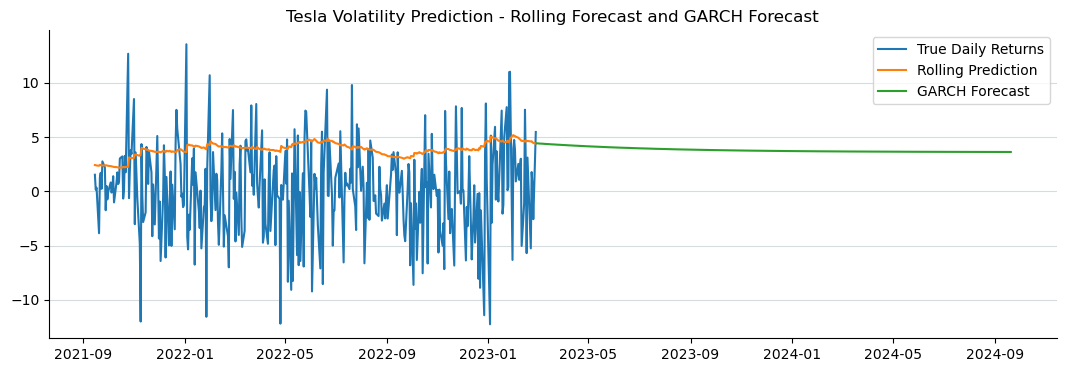

In [48]:
fig, ax = plt.subplots(figsize=(13, 4))
ax.grid(which="major", axis='y', color='#758D99', alpha=0.3, zorder=1)
ax.spines[['top','right']].set_visible(False)
plt.plot(tsla_data['Return'][-365:])
plt.plot(rolling_predictions)
plt.plot(forecast)
plt.title('Tesla Volatility Prediction - Rolling Forecast and GARCH Forecast')
plt.legend(['True Daily Returns', 'Rolling Prediction', 'GARCH Forecast'])

In [64]:
annual_volatility = daily_volatility * np.sqrt(252)
print("Projected annual volatility:", annual_volatility)
print('The annualized volatility from today until 20th September 2024 is:', round(annualized_volatility, 2))

Projected annual volatility: 57.427022111834475
The annualized volatility from today until 20th September 2024 is: 4.6


## The Projected annual volatiltiy is : 57.43%

### The predicted daily volatility value at the end of the forecast horizon (20th September 2024) is: 3.61